# SSAM analysis of mouse POA, imaged by MERFISH
- Author: Jeongbin Park
- Date: 2019-10-13

Set plot parametes / define helper functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn import preprocessing
import pickle

In [2]:
## Parameters for post-filtering of cell type maps
filter_method = "local"
filter_params = {
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": 0.1
}

In [3]:
# Helper function to load precomputed tSNE
def load_tsne(tsne_id):
    with open("zenodo/MERFISH/tsne/%s.pkl"%tsne_id, "rb") as f:
        ds.tsne = pickle.load(f)

In [4]:
from matplotlib.colors import to_rgba, to_hex

# Helper function to create shades of given color
def generate_shades(col, maxlen, percentage):
    def mix_color(c1, c2, percentage):
        w = percentage / 100.0
        return c1 * (1 - w) + c2 * w
    
    isstr = False
    if type(col) is str:
        col = to_rgba(col)
        isstr = True
        
    col = np.array(col)
    white = np.array([1, 1, 1, 1])
    black = np.array([0, 0, 0, 1])

    len_darks = int(np.floor(maxlen / 2))
    len_brights = len_darks + (0 if maxlen % 2 == 0 else 1)

    shades = []
    for i in range(len_brights):
        if percentage * i > 100.0:
            break
        shades.append(mix_color(col, white, percentage * i))
    shades = shades[::-1]
    for i in range(1, len_darks + 1):
        if percentage * i > 100.0:
            break
        shades.append(mix_color(col, black, percentage * i))
    
    shades = tuple(shades)
    if isstr:
        shades = [to_hex(e) for e in shades]
        
    return shades

In [5]:
# Helper function to shorten cluster labels
def shorten_labels(lbls):
    l = []
    for lbl in lbls:
        l.append(lbl.
                 replace("Inhibitory", "Inhib.").
                 replace("Excitatory", "Excit.")
                )
    return l

## Load data

Load mRNA spot locations

In [6]:
import numpy as np
from collections import defaultdict

pos_dic = defaultdict(lambda: [])

with open("zenodo/MERFISH/raw_data/merfish_barcodes_example.csv") as f:
    f.readline()
    for line in f:
        e = line.rstrip().split(',')
        g, x, y, z = e[0], e[6], e[7], e[8]
        if g in ['Blank-1', 'Blank-2', 'Blank-3', 'Blank-4', 'Blank-5']:
            continue
        x, y, z = float(x), float(y), float(z)
        pos_dic[g].append([x, y, z])

all_genes = list(pos_dic.keys())
for g in pos_dic:
    pos_dic[g] = np.array(pos_dic[g])

## SSAM analysis
### Run KDE and select representative vectors

Initilize SSAM and run KDE

In [7]:
import ssam

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
width = 1790
height = 1790
depth = 9

In [9]:
all_genes = list(pos_dic.keys())
ds = ssam.SSAMDataset(all_genes, [pos_dic[gene] for gene in all_genes], width, height, depth)
analysis = ssam.SSAMAnalysis(ds, ncores=10, save_dir="zenodo/MERFISH/kde", verbose=True)

In [10]:
analysis.run_kde(bandwidth=2.5, use_mmap=False)

Select local maxima of gene expression in the vector field

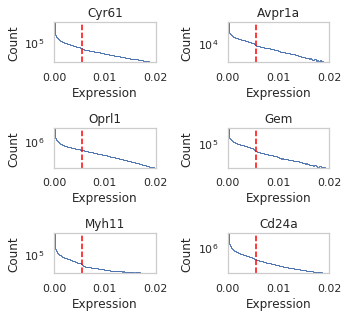

In [11]:
exp_thres = 0.0055
viewport = 0.02
gindices = np.arange(len(ds.genes))
np.random.shuffle(gindices)
plt.figure(figsize=[5, 7])
for i, gidx in enumerate(gindices[:6], start=1):
    ax = plt.subplot(5, 2, i)
    n, bins, patches = ax.hist(ds.vf[..., gidx][np.logical_and(ds.vf[..., gidx] > 0, ds.vf[..., gidx] < viewport)], bins=100, log=True, histtype=u'step')
    ax.set_xlim([0, viewport])
    ax.set_ylim([n[0], n[-1]])
    ax.axvline(exp_thres, c='red', ls='--')
    ax.set_title(ds.genes[gidx])
    ax.set_xlabel("Expression")
    ax.set_ylabel("Count")
plt.tight_layout()
pass

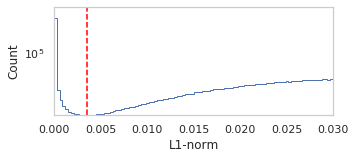

In [12]:
gidx = 0
norm_thres = 0.0035
plt.figure(figsize=[5, 2])
n, _, _ = plt.hist(ds.vf_norm[np.logical_and(ds.vf_norm > 0, ds.vf_norm < 0.03)], bins=100, log=True, histtype='step')
ax = plt.gca()
ax.axvline(norm_thres, c='red', ls='--')
ax.set_xlabel("L1-norm")
ax.set_ylabel("Count")

plt.xlim([0, 0.03])
plt.ylim([np.min(n), np.max(n) + 100000])
pass

In [13]:
analysis.find_localmax(search_size=3, min_norm=norm_thres, min_expression=exp_thres)

Found 13666 local max vectors.


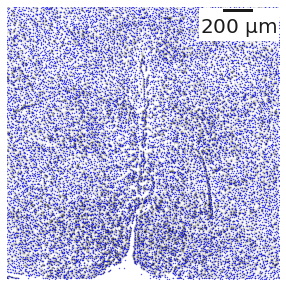

In [14]:
plt.figure(figsize=[5, 5])
ds.plot_l1norm(cmap="Greys", rotate=3)
ds.plot_localmax(c="blue", rotate=3, s=0.1)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
plt.show()

Normalize local maxima vectors and vector field

Writing temporary files...
Running scTransform via Rscript...
Reading output files...


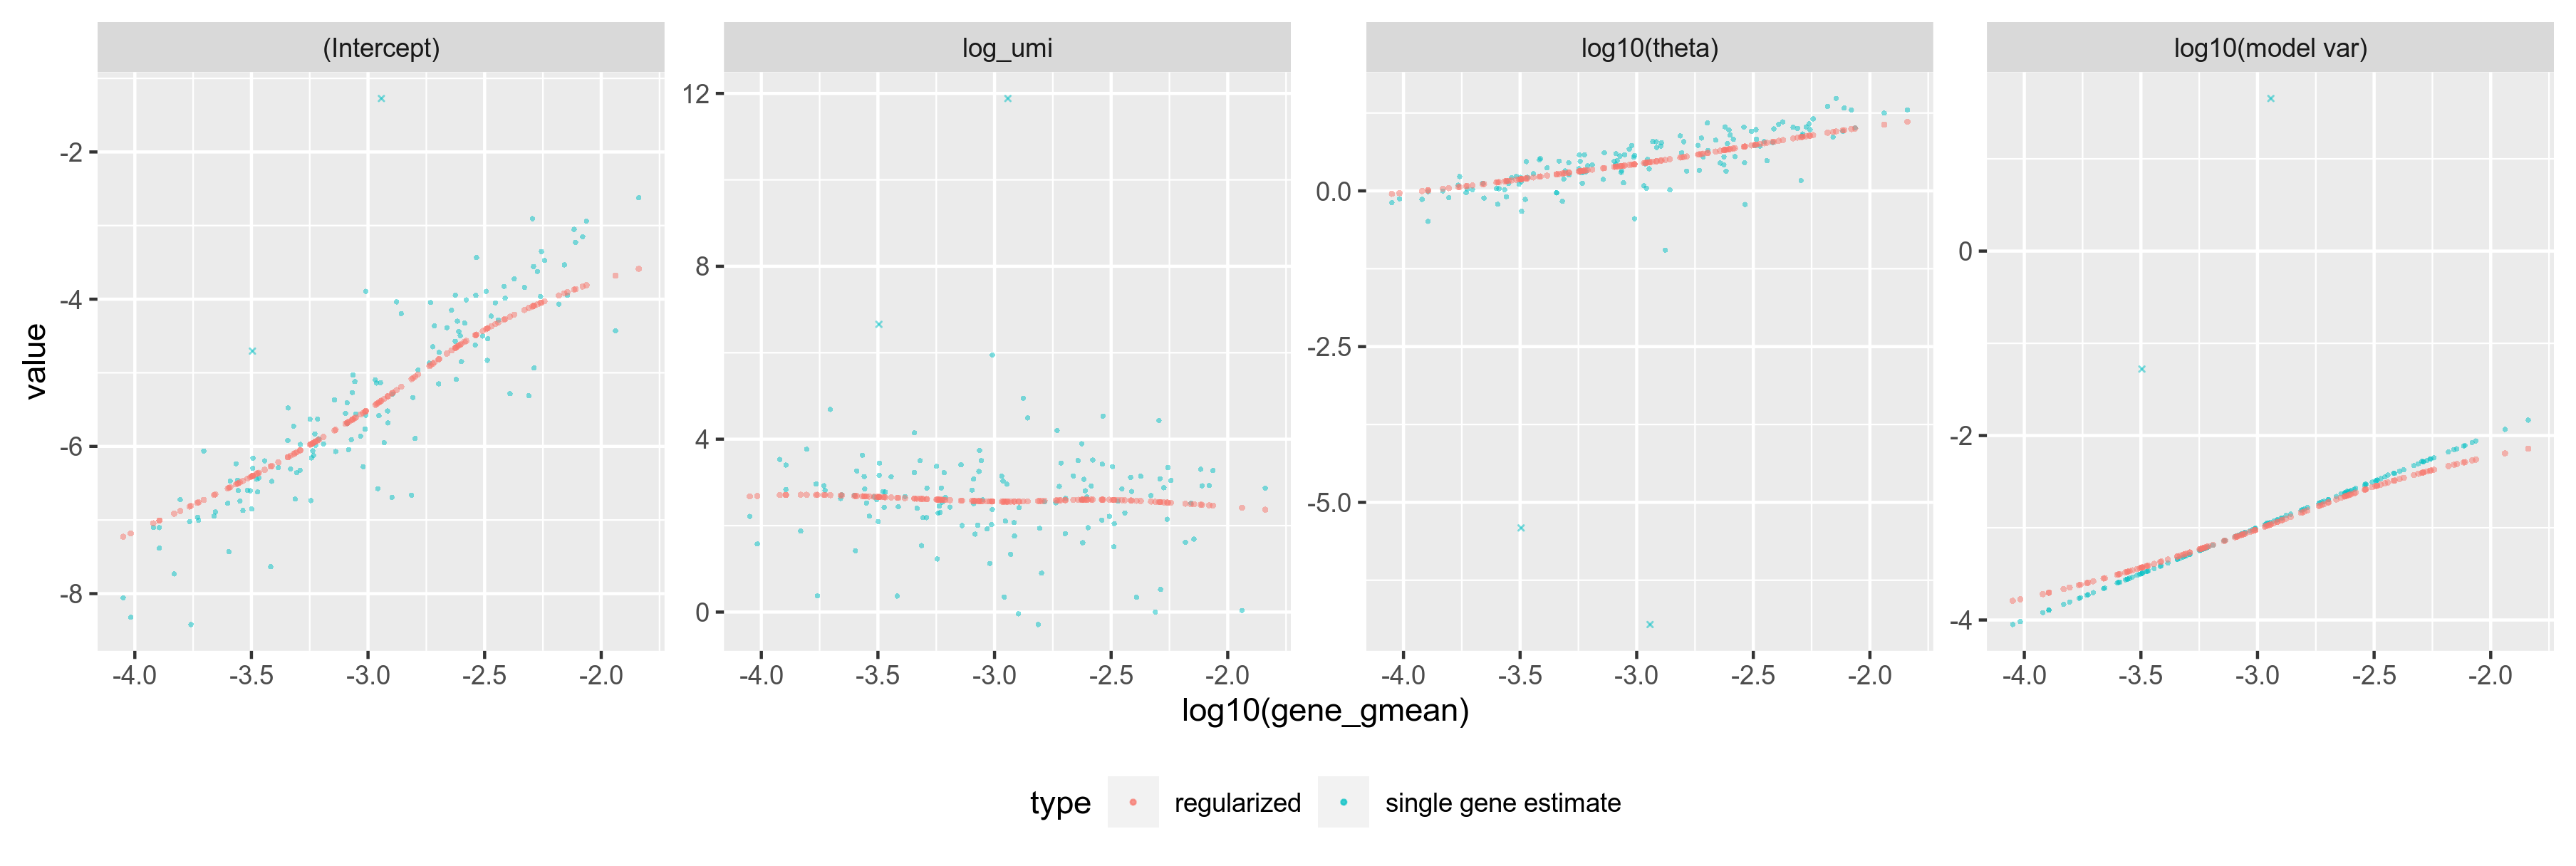

Clipping residuals...


In [ ]:
# this requires local R installation with packages 'sctransform' and 'feather'
analysis.normalize_vectors_sctransform(vst_kwargs={'plot_model_pars': True})

## SSAM guided mode: using MERFISH segmentation-based centroids and scRNA-seq data (Moffit *et al*.)

### 1) SSAM guided by segmentation-based cluster centroids

Load MERFISH segementation-based expression data

In [16]:
# Load slice at -0.24 (the most posterior slice)
selected_z = "-0.24"
cid_dic = {}
cid_nct_dic = {}
merfish_gene_expressions = defaultdict(lambda: [])
with open("zenodo/MERFISH/raw_data/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv") as f:
    line = f.readline()
    entries = line.strip().split(',')
    merfish_genes = entries[9:]
    for line in f:
        entries = line.strip().split(',')
        cid, aid, z, cell_type, neuron_cell_type = entries[0], entries[1], entries[4], entries[7], entries[8]
        if aid != '1':
            continue
        elif cell_type == "Ambiguous":
            continue
        if z == selected_z:
            cid_dic[cid] = cell_type
            cid_nct_dic[cid] = neuron_cell_type
            if cell_type == "Inhibitory" or cell_type == "Excitatory":
                cell_type = neuron_cell_type
            merfish_gene_expressions[cell_type].append([float(e) for e in entries[9:]])

In [17]:
merfish_gene_indices = [merfish_genes.index(gene) for gene in ds.genes]
merfish_genes = np.array(merfish_genes)[merfish_gene_indices]
for cl in merfish_gene_expressions:
    merfish_gene_expressions[cl] = np.array(merfish_gene_expressions[cl])[:, merfish_gene_indices]

In [18]:
merfish_uniq_labels = np.array(sorted(merfish_gene_expressions.keys()))
merfish_centroids = np.zeros([len(merfish_uniq_labels), len(ds.genes)])

for cl_idx, cl in enumerate(merfish_uniq_labels):
    merfish_centroids[cl_idx, :] = np.mean(merfish_gene_expressions[cl], axis=0)

In [113]:
import pickle
with open("merfish_centroids.pkl", "wb") as f:
    pickle.dump(ds.centroids, f)

Map it to vector field

In [19]:
analysis.map_celltypes(merfish_centroids)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.5)

In [32]:
# The colors below is extracted from Figure 3 of Moffit et al. (2018)
cell_class_colors = {
    'Inhibitory': '#ef2420',
    'Excitatory': '#59a3e4',
    'Mature OD': '#79c535',
    'Immature OD': '#d7439b',
    'Astrocyte': '#94544c',
    'Microglia': '#e51c98',
    'Ependymal': '#5355b8',
    'Endothelial': '#ffd109',
    'Mural': '#fb982b'
}

In [21]:
# Define cluster colors based on the cell-class colors
merfish_colors_dic = {}
for cl in merfish_uniq_labels:
    if cl[:2] == "E-":
        merfish_colors_dic[cl] = cell_class_colors['Excitatory']
    elif cl[:2] == "I-" or cl[:2] == "H-":
        merfish_colors_dic[cl] = cell_class_colors['Inhibitory']
    elif 'Mature' in cl:
        merfish_colors_dic[cl] = cell_class_colors['Mature OD']
    elif 'Immature' in cl:
        merfish_colors_dic[cl] = cell_class_colors['Immature OD']
    elif 'Endothelial' in cl:
        merfish_colors_dic[cl] = cell_class_colors['Endothelial']
    elif cl == 'Pericytes':
        merfish_colors_dic[cl] = cell_class_colors['Mural']
    else:
        merfish_colors_dic[cl] = cell_class_colors[cl]
merfish_colors = [merfish_colors_dic[cl] for cl in merfish_uniq_labels]

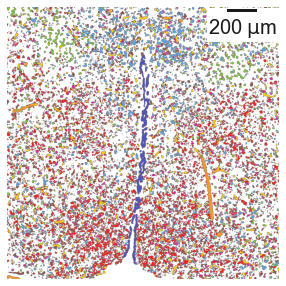

In [22]:
plt.figure(figsize=[5, 5])
ds.plot_celltypes_map(rotate=3, background='white', colors=merfish_colors, set_alpha=False)
from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
plt.show()

In [36]:
lbl_bot, lbl_left, df, ms_heatmap = calc_matching_score(merfish_centroids, merfish_uniq_labels)
pd.set_option('display.max_rows', df.shape[0]+1)
df

Reference cell types Given cell types  Pearson's r  Matched segments  \
0             Astrocyte        Astrocyte          1.0               740   
1                   E-1              E-1          1.0                14   
2                  E-10             E-10          1.0                 7   
3                  E-11             E-11          1.0                 5   
4                  E-12             E-12          1.0                12   
5                  E-13             E-13          1.0               100   
6                  E-14             E-14          1.0               240   
7                  E-15             E-15          1.0                44   
8                  E-16             E-16          1.0               127   
9                  E-17             E-17          1.0                22   
10                 E-18             E-18          1.0                69   
11                 E-19             E-19          1.0                48   
12                  E-2              E-2          1.0                 4   
13                 E-20             E-20          1.0                 6   
14                 E-21             E-21          1.0                 5   
15                 E-22             E-22          1.0                 0   
16                 E-23             E-23          1.0                25   
17                 E-24             E-24          1.0                27   
18                 E-25             E-25          1.0                 2   
19                 E-26             E-26          1.0                 1   
20                 E-28             E-28          1.0                19   
21                 E-29             E-29          1.0                 1   
22                  E-3              E-3          1.0                13   
23                 E-30             E-30          1.0                 1   
24                 E-31             E-31          1.0                 2   
25                  E-4              E-4          1.0                27   
26                  E-5              E-5          1.0                 1   
27                  E-6              E-6          1.0                16   
28                  E-7              E-7          1.0                47   
29                  E-8              E-8          1.0                14   
30                  E-9              E-9          1.0                19   
31        Endothelial 1    Endothelial 1          1.0               290   
32        Endothelial 2    Endothelial 2          1.0                17   
33        Endothelial 3    Endothelial 3          1.0               112   
34            Ependymal        Ependymal          1.0               219   
35                  H-1              H-1          1.0                 1   
36                  I-1              I-1          1.0                 1   
37                 I-10             I-10          1.0                15   
38                 I-11             I-11          1.0                66   
39                 I-12             I-12          1.0               110   
40                 I-13             I-13          1.0               226   
41                 I-14             I-14          1.0                75   
42                 I-15             I-15          1.0               165   
43                 I-16             I-16          1.0                77   
44                 I-18             I-18          1.0               116   
45                 I-19             I-19          1.0                 5   
46                  I-2              I-2          1.0                77   
47                 I-20             I-20          1.0                10   
48                 I-21             I-21          1.0                 3   
49                 I-22             I-22          1.0                 6   
50                 I-23             I-23          1.0                70   
51                 I-24             I-24          1.0                12   
52                 I-25     

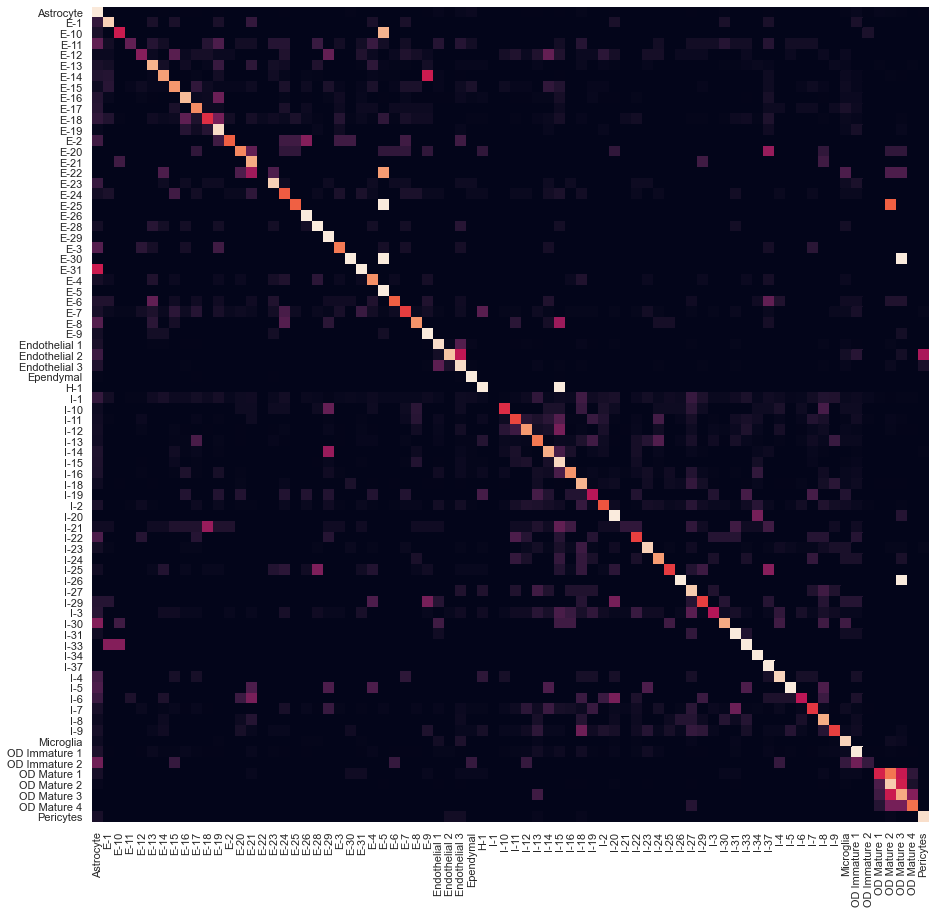

In [35]:
plt.figure(figsize=[15, 15])
sns.heatmap(ms_heatmap,
            yticklabels=lbl_bot,
            xticklabels=lbl_left, cbar=False, vmin=0, vmax=1)
pass

### 2) SSAM guided by scRNA-seq cluster centroids

Load scRNA-seq data

In [37]:
import gzip
scrna_genes = []
with gzip.open("zenodo/MERFISH/raw_data/GSE113576_genes.tsv.gz", "rt") as f:
    for line in f:
        ensid, gene = line.rstrip().split('\t')
        # Correct gene name
        if gene == '4732456N10Rik':
            gene = "Krt90"
        scrna_genes.append(gene)
        
scrna_barcodes = []
with gzip.open("zenodo/MERFISH/raw_data/GSE113576_barcodes.tsv.gz", "rt") as f:
    for line in f:
        scrna_barcodes.append(line.rstrip())

In [38]:
from scipy.io import mmread
with gzip.open("zenodo/MERFISH/raw_data/GSE113576_matrix.mtx.gz") as f:
    scrna_expmat = mmread(f)

In [39]:
# Normalize it with sctransform
norm_scrna_expmat = ssam.run_sctransform(scrna_expmat.T.todense(), min_cells=1)[0]

In [40]:
key_to_gene = {'%d'%i: g for i, g in enumerate(scrna_genes)}
filtered_scrna_genes = [key_to_gene[i] for i in norm_scrna_expmat.keys()]
gidx = [g in ds.genes for g in filtered_scrna_genes]
scrna_expmat_reduced = np.array(norm_scrna_expmat)[:, np.where(gidx)[0]]
scrna_genes_reduced = list(np.array(filtered_scrna_genes)[gidx])
sorted_gidx = [scrna_genes_reduced.index(g) for g in ds.genes]
scrna_expmat_final = scrna_expmat_reduced[:, sorted_gidx]

In [41]:
scrna_cluster_dic = {}
scrna_cluster_dic2 = {}

# Downloaded from supp. material of Moffit et al, table S1
# This file contains cluster metadata
table_s1_df = pd.read_excel("zenodo/MERFISH/raw_data/aau5324_Moffitt_Table-S1.xlsx", skiprows=[0,1], header=None)
table_s1_df = table_s1_df.fillna('')
for _, (bc, _, _, c1, c2, c3) in table_s1_df.iterrows():
    if c2 == '' and c3 == '':
        c2 = c1 # Ambiguous and Unstable
    elif c2 == '':
        c2 = c1 + ' (' + c3 + ')'
        
    scrna_cluster_dic[bc] = c1
    scrna_cluster_dic2[bc] = c2

In [42]:
scrna_cluster_labels = [scrna_cluster_dic2[e] for e in scrna_barcodes]
scrna_uniq_labels = sorted(filter(lambda e: not e in ['Ambiguous', 'Unstable'], set(scrna_cluster_labels)))

In [43]:
scrna_centroids = []
for c in scrna_uniq_labels:
    scrna_centroids.append(np.mean(scrna_expmat_final[np.array(scrna_cluster_labels) == c, :], axis=0))

Map it to the vector field

In [44]:
analysis.map_celltypes(scrna_centroids)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.5)

In [45]:
# Define color of scRNAseq data
scrna_colors_dic = {}
for cl in scrna_uniq_labels:
    if cl == "Fibroblast 1":
        scrna_colors_dic[cl] = "black"
        continue
    elif cl == "Macrophage 1":
        scrna_colors_dic[cl] = "grey"
        continue
    r_cl = cl.replace("oligodendrocyte", 'OD').replace('Newly formed', 'Immature')
    for cate in cell_class_colors:
        if cate in r_cl:
            scrna_colors_dic[cl] = cell_class_colors[cate]
            break
scrna_colors = [scrna_colors_dic[cl] for cl in scrna_uniq_labels]

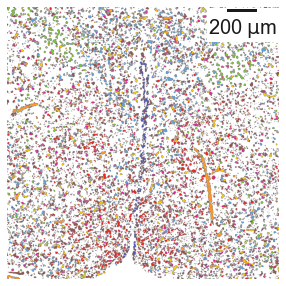

In [46]:
plt.figure(figsize=[5, 5])
ds.plot_celltypes_map(rotate=3, background='white', colors=scrna_colors, set_alpha=False)
from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
plt.show()

In [47]:
lbl_bot, lbl_left, df, ms_heatmap = calc_matching_score(scrna_centroids, scrna_uniq_labels)
df

Reference cell types            Given cell types  Pearson's r  \
0            Astrocyte                Astrocytes 2         0.91   
1        Endothelial 3               Endothelial 3         0.90   
2                  E-5    Excitatory (e8:Cck/Ebf3)         0.86   
3        OD Immature 1  Immature oligodendrocyte 1         0.90   
4            Microglia                 Microglia 2         0.97   

   Matched segments  Total segments  Matching score  
0               567             745            0.76  
1                84             117            0.72  
2                 1               1            1.00  
3               221             223            0.99  
4               100             106            0.94

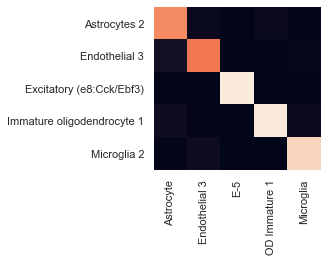

In [52]:
plt.figure(figsize=[3, 3])
sns.heatmap(ms_heatmap,
            yticklabels=lbl_bot,
            xticklabels=lbl_left, cbar=False, vmin=0, vmax=1)
pass

## SSAM *de novo* mode

In [16]:
analysis.cluster_vectors(pca_dims=60, resolution=0.15, max_correlation=1.0, metric="correlation", centroid_correction_threshold=0.6)

Found 68 clusters


In [50]:
filter_params['offset'] = 0
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, min_blob_area=7, fill_blobs=True)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=[5, 5])
ds.plot_celltypes_map(rotate=3, background='white', set_alpha=False)

scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
plt.show()

In [ ]:
load_tsne('excluded')

In [ ]:
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=60, metric="correlation", s=5, run_tsne=False)
plt.axis('off')

In [ ]:
from scipy.stats import pearsonr, spearmanr

for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx, known_signatures=[
        ("segmentation", merfish_uniq_labels, merfish_centroids, merfish_colors),
        ("scRNA-seq", scrna_uniq_labels, scrna_centroids, scrna_colors),
    ], correlation_methods=[
        ("r", pearsonr),
    ])
    plt.tight_layout()
    plt.savefig('diagplots_MERFISH/diagplot_centroid_%d.png'%idx)
    plt.close()

In [17]:
denovo_labels = [
    "Astrocyte 2",
    "Astrocyte 2",
    "Astrocyte 1",
    "Excitatory Cbln2",
    "Excitatory Nos1",
    "Astrocyte 1",
    "Inhibitory Sytl4",
    "Mature OD 3 (Lpar1)",
    "Astrocyte 1",
    "N/A", # Too few vectors
    
    "Immature OD",
    "Inhibitory Syt2,Ramp3",
    "N/A", # Too few vectors
    "Excitatory Necab1",
    "Inhibitory Amigo2,Sema3c",
    "Inhibitory Dgkk",
    "N/A",
    "Inhibitory Esr1",
    "Inhibitory Arhgap36,Gda",
    "Inhibitory Gad1",
    
    "Astrocyte 2",
    "Inhibitory Gda",
    "Endothelial 2",
    "Astrocyte 1",
    "Inhibitory Arhgap36",
    "Excitatory Syt4",
    "Inhibitory Synpr",
    "Excitatory Fezf1",
    "Inhibitory Tacr1",
    "Excitatory Cbln1,Cbln2 (e19)",
    
    "Mature OD 2",
    "Mural",
    "Inhibitory Gpr165,Gda",
    "Excitatory Necab1,Gda",
    "Inhibitory Gpr165",
    "N/A", # only one vector, not mapped to anywhere
    "N/A", # Astrocyte + Sox4 contamination
    "N/A", # Contamination?
    "Inhibitory Amigo2",
    "Inhibitory Col25a1",
    
    "N/A",
    "Inhibitory Cxcl14",
    "N/A", # Astrocyte + Sox2 contamination
    "Mature OD 1",
    "Endothelial 3",
    "Microglia",
    "Excitatory Ebf3",
    "Mature OD 2",
    "Inhibitory Calcr",
    "Endothelial 1",
    
    "Excitatory Col25a1",
    "Excitatory Cbln2,Nos1",
    "Excitatory Irs4",
    "N/A", # Too few vectors
    "Inhibitory Coch",
    "N/A",
    "Inhibitory Tacr3",
    "Inhibitory Prlr",
    "Excitatory Omp",
    "Ependymal",
    
    "Excitatory Pcdh11x",
    "Inhibitory Irs4",
    "N/A",
    "Inhibitory Mixed Irs4",
    "Inhibitory Arhgap36,Mlc1",
    "Inhibitory Oprd1",
    "Inhibitory Fbxw13",
    "N/A",
]

In [18]:
denovo_labels_final = []
exclude_indices = []
merge_indices = []
import re

p = re.compile(r' \(.*\)')

denovo_labels_short = [p.sub("", cl) for cl in denovo_labels]
for idx, cl in enumerate(denovo_labels_short):
    if cl == 'N/A':
        exclude_indices.append(idx)
        continue
    if cl in denovo_labels_final:
        continue
    denovo_labels_final.append(cl)
for cl in np.unique(denovo_labels_short):
    if cl == 'N/A':
        continue
    mask = [cl == e for e in denovo_labels_short]
    if np.sum(mask) > 1:
        merge_indices.append(np.where(mask)[0])

In [ ]:
cmap = plt.get_cmap('jet')
jet_colors = cmap(np.array(list(range(len(ds.centroids)))) / (len(ds.centroids) - 1))
tsne_colors = np.zeros_like(jet_colors)
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
tsne_colors[exclude_indices] = [0, 0, 0, 1] #jet_colors[exclude_indices]

import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.axis('off')

In [ ]:
cmap = plt.get_cmap('rainbow')
jet_colors = cmap(np.array(list(range(len(merge_indices)))) / (len(merge_indices) - 1))
plt.figure(figsize=[5, 5])
tsne_colors = np.zeros([len(ds.centroids), 4])
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
for idx, mi in enumerate(merge_indices):
    tsne_colors[mi] = jet_colors[idx]
    ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.axis('off')

In [19]:
analysis.exclude_and_merge_clusters(exclude_indices, merge_indices, centroid_correction_threshold=0.6)

/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/ssam-1.0.1-py3.8-linux-x86_64.egg/ssam/__init__.py:1203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  merge = np.array(merge)


In [33]:
# Set cluster colors the same as category colors
denovo_celltype_colors = []
for cl in denovo_labels_final:
    for c_cl in cell_class_colors:
        if c_cl in cl:
            col = cell_class_colors.get(c_cl)
            break
    denovo_celltype_colors.append(col)

In [35]:
# Generate unique cluster colors as shades of category colors
denovo_celltype_colors_shades = np.array(denovo_celltype_colors, copy=True)
for col in set(denovo_celltype_colors):
    same_color_indices = np.where(np.array(denovo_celltype_colors) == col)[0]
    if len(same_color_indices) > 3:
        percentage = 5
    else:
        percentage = 30
    shades = generate_shades(col, len(same_color_indices), percentage)
    denovo_celltype_colors_shades[same_color_indices] = shades

In [46]:
load_tsne('merged')

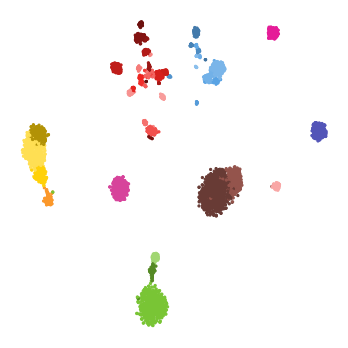

In [47]:
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=60, metric="correlation", s=5, run_tsne=False, colors=denovo_celltype_colors_shades)
plt.gca().axis('off')
plt.tight_layout()

In [42]:
heatmap_cell_class_ordered = [
    "Inhibitory",
    "Excitatory",
    "Mature OD",
    "Immature OD",
    "Astrocyte",
    "Microglia",
    "Ependymal",
    "Endothelial",
    "Mural",
]

In [43]:
heatmap_clusters_ordered = []
for i, cate in enumerate(heatmap_cell_class_ordered):
    for j, cl in enumerate(denovo_labels_final):
        if cate in cl:
            heatmap_clusters_ordered.append(cl)
heatmap_clusters_index = [denovo_labels_final.index(cl) for cl in heatmap_clusters_ordered]

In [44]:
from matplotlib.colors import to_rgba, to_hex

heatmap_vectors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), len(ds.genes)], dtype=float)
col_colors_cellclass = np.zeros(np.sum(ds.filtered_cluster_labels != -1), dtype='<U7')
col_colors_celltype = np.zeros(np.sum(ds.filtered_cluster_labels != -1), dtype='<U7')
acc_idx = 0
acc_sizes = []
for cl_idx in heatmap_clusters_index:
    cl_vecs = ds.normalized_vectors[ds.filtered_cluster_labels == cl_idx]
    acc_sizes.append(cl_vecs.shape[0])
    heatmap_vectors[acc_idx:acc_idx+cl_vecs.shape[0], :] = cl_vecs

    col = denovo_celltype_colors[cl_idx]
    col_colors_cellclass[acc_idx:acc_idx+cl_vecs.shape[0]] = to_hex(col)

    col = denovo_celltype_colors_shades[cl_idx]
    col_colors_celltype[acc_idx:acc_idx+cl_vecs.shape[0]] = to_hex(col)
    
    acc_idx = np.sum(acc_sizes)

In [45]:
heatmap_genes_index = []
heatmap_genes_ordered = []
_, i = np.unique(col_colors_celltype, return_index=True)
uc = col_colors_celltype[sorted(i)]
mean_genes = np.zeros([len(uc), len(ds.genes)])
for i, c in enumerate(uc):
    mean_genes[i, :] = np.mean(heatmap_vectors[col_colors_celltype == c], axis=0)

max_exp_indices = np.argmax(mean_genes, axis=0)
for i in range(len(uc)):
    cl_gene_indices = np.where(max_exp_indices == i)[0]
    heatmap_genes_index += list(cl_gene_indices)
    heatmap_genes_ordered += list(np.array(ds.genes)[cl_gene_indices])
heatmap_vectors = heatmap_vectors[:, heatmap_genes_index]

In [110]:
ds.normalized_vectors[ds.filtered_cluster_labels > -1].shape

(4714, 135)

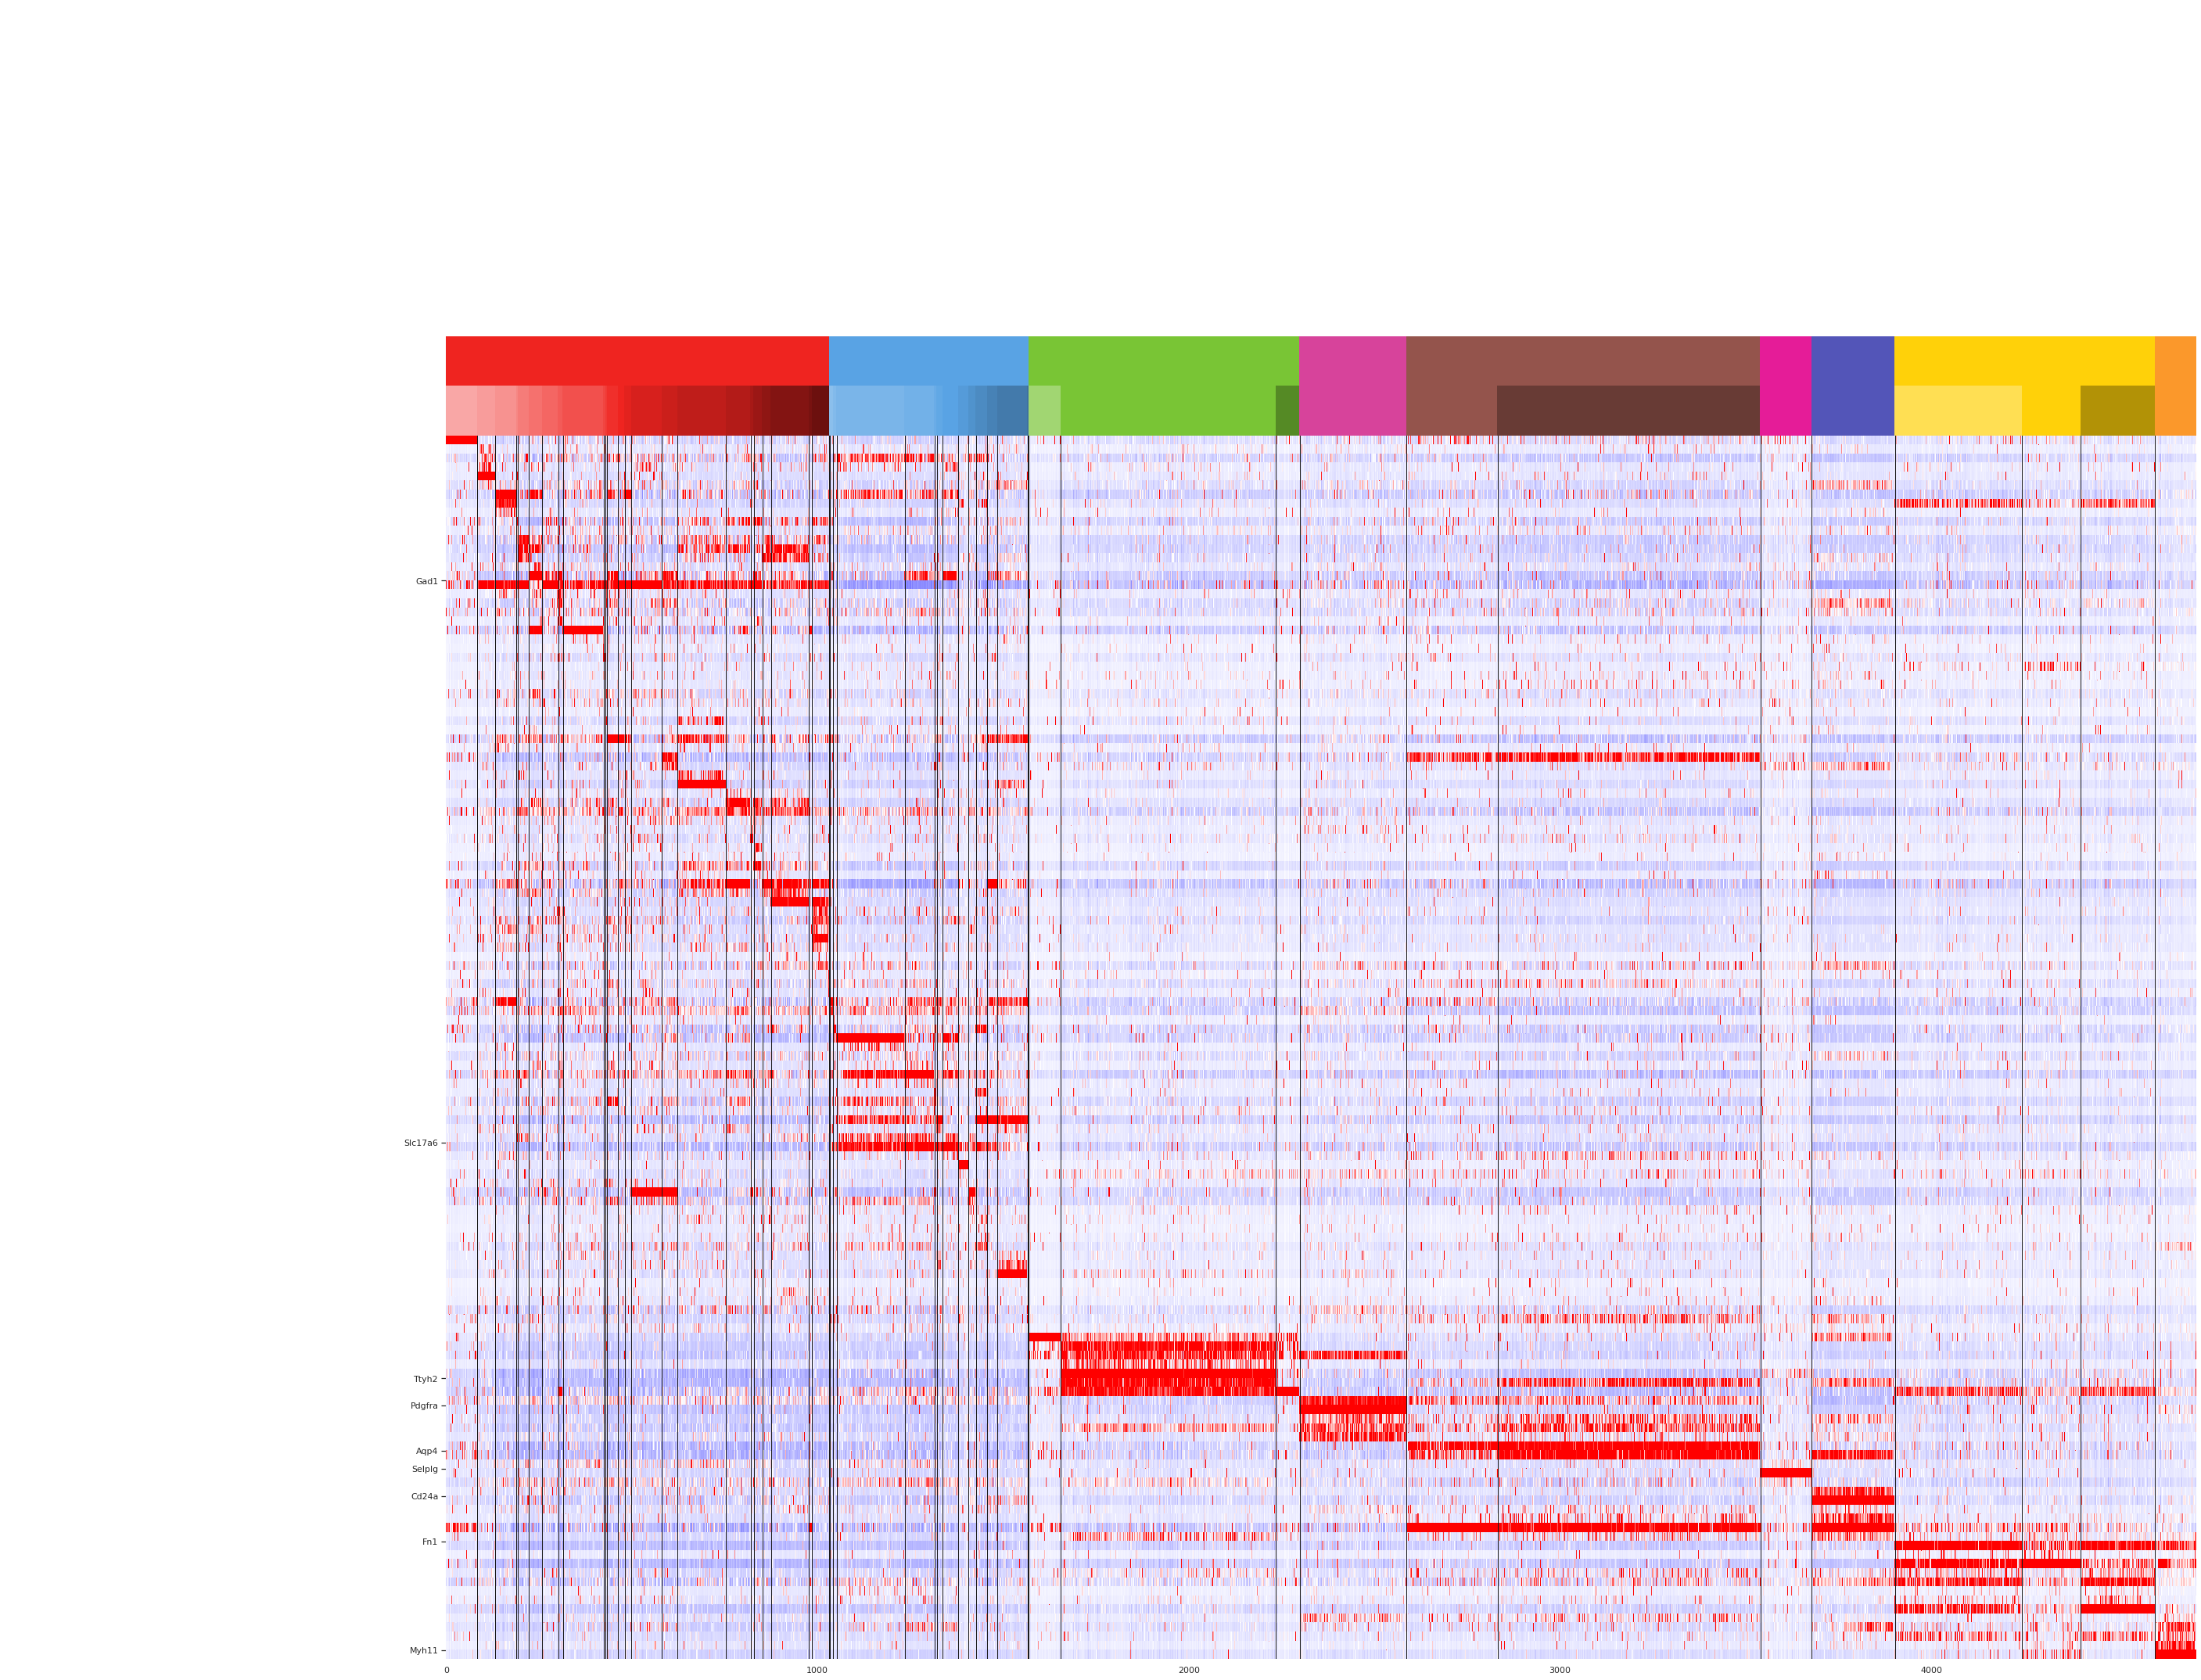

In [72]:
import seaborn as sns
gene_exp_heatmap = heatmap_vectors.T
gene_exp_heatmap = preprocessing.scale(gene_exp_heatmap)
heatmap_genes_selected = ["Gad1", "Slc17a6", "Ttyh2", "Pdgfra", "Aqp4", "Selplg", "Cd24a", "Fn1", "Myh11"]
heatmap_genes_selected_indices = [heatmap_genes_ordered.index(gene) for gene in heatmap_genes_selected]
g = sns.clustermap(gene_exp_heatmap, figsize=[40, 30], yticklabels=heatmap_genes_selected,
                 cmap='bwr', row_cluster=False, col_cluster=False,
                 col_colors=[col_colors_cellclass, col_colors_celltype], xticklabels = 1000, vmin=-2.5, vmax=2.5)
g.cax.set_visible(False)
g.ax_heatmap.set_yticks(heatmap_genes_selected_indices)
g.ax_heatmap.tick_params(labelright=False, labelleft=True, right=False, left=True)
for i in range(1, len(col_colors_celltype)):
    if col_colors_celltype[i] != col_colors_celltype[i-1]:
        g.ax_heatmap.axvline(i, 0, gene_exp_heatmap.shape[0], lw=1, c='k')

In [20]:
good_vectors = ds.vf[ds.local_maxs][ds.filtered_cluster_labels > -1]
import doubletdetection
clf = doubletdetection.BoostClassifier(use_phenograph=False) # use_phenograph causes error; setting this False to use Louvain clustering
labels = clf.fit(good_vectors).predict()

In [26]:
np.sum(labels == 1) / len(labels) * 100

3.3729316928298685

In [25]:
import scrublet as scr
eps = np.finfo(float).eps
scrub = scr.Scrublet(good_vectors)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=eps, min_cells=eps, min_gene_variability_pctl=eps)

Preprocessing...
Simulating doublets...


/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:251: RuntimeWarning: invalid value encountered in sqrt
  CV_eff = np.sqrt((1+a)*(1+b) - 1);
/icgc/dkfzlsdf/analysis/B260/users/parkj/miniconda3/envs/oldssam/lib/python3.8/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 2.3 seconds


In [47]:
def shorten_labels(lbls):
    l = []
    for lbl in lbls:
        lbl = lbl[0].capitalize() + lbl[1:]
        l.append(lbl
                 .replace("Inhibitory ", "Inhibitory\n")
                 .replace("Excitatory ", "Excitatory\n")
                )
    return l
heatmap_clusters_ordered_short = shorten_labels(heatmap_clusters_ordered)

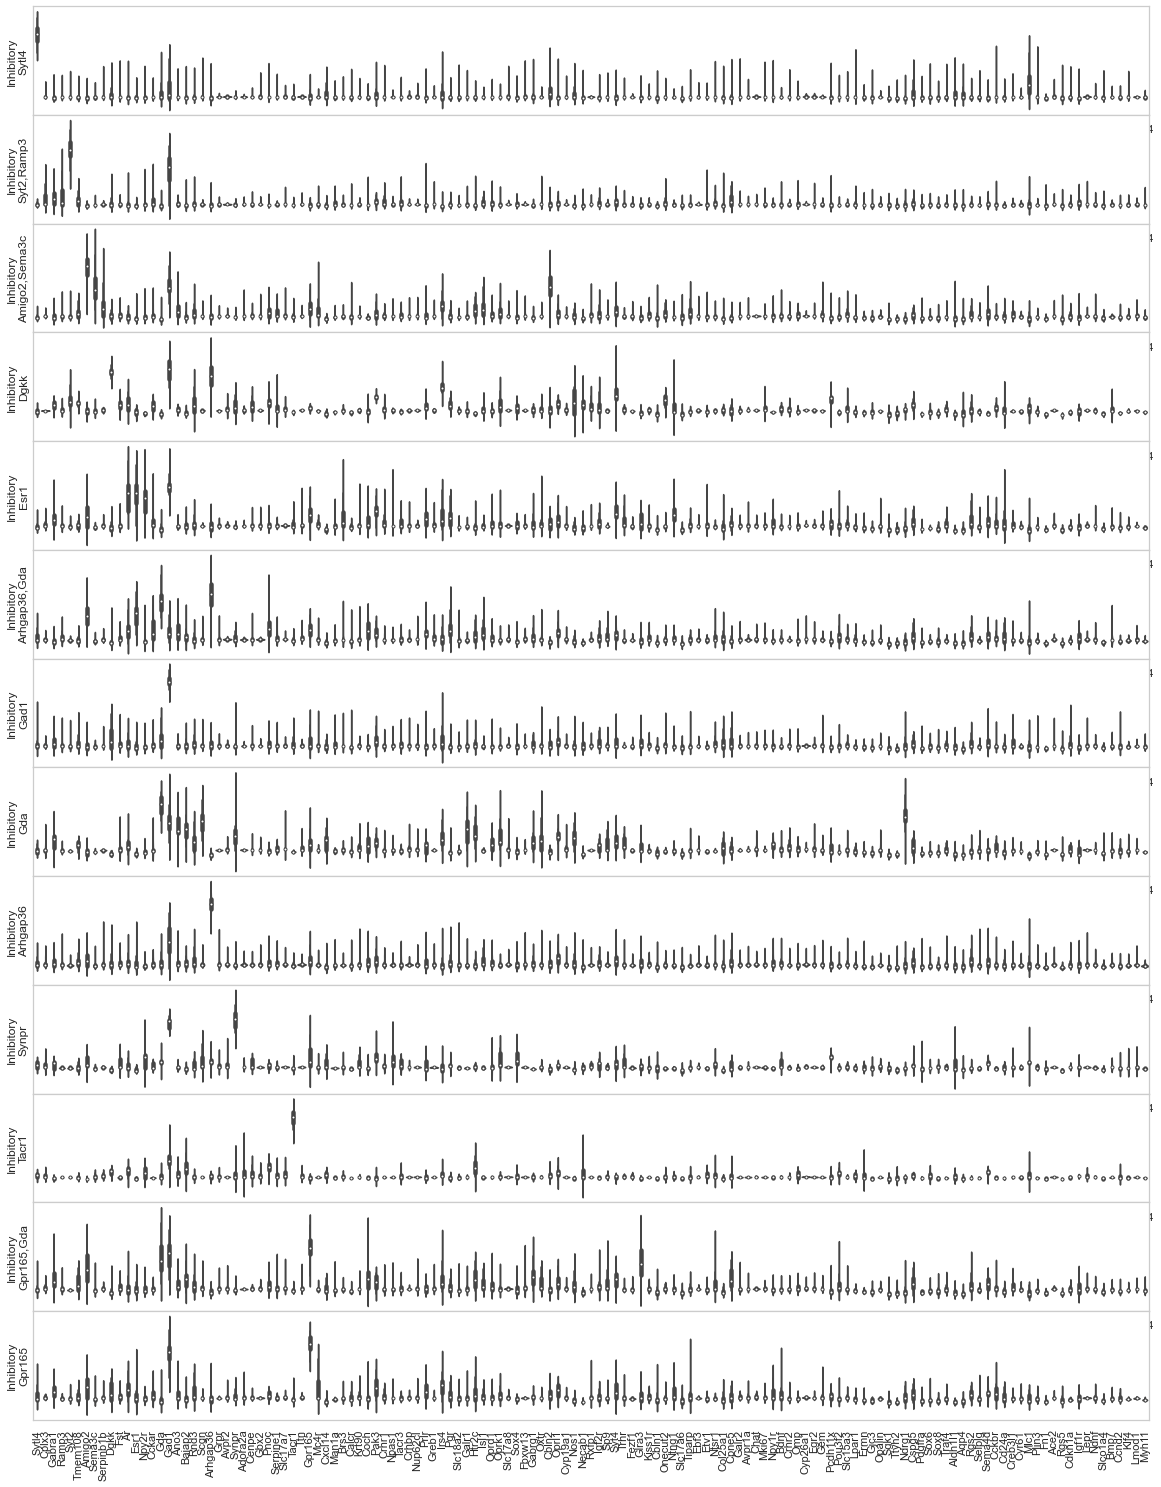

In [48]:
s = 0
e = 13

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

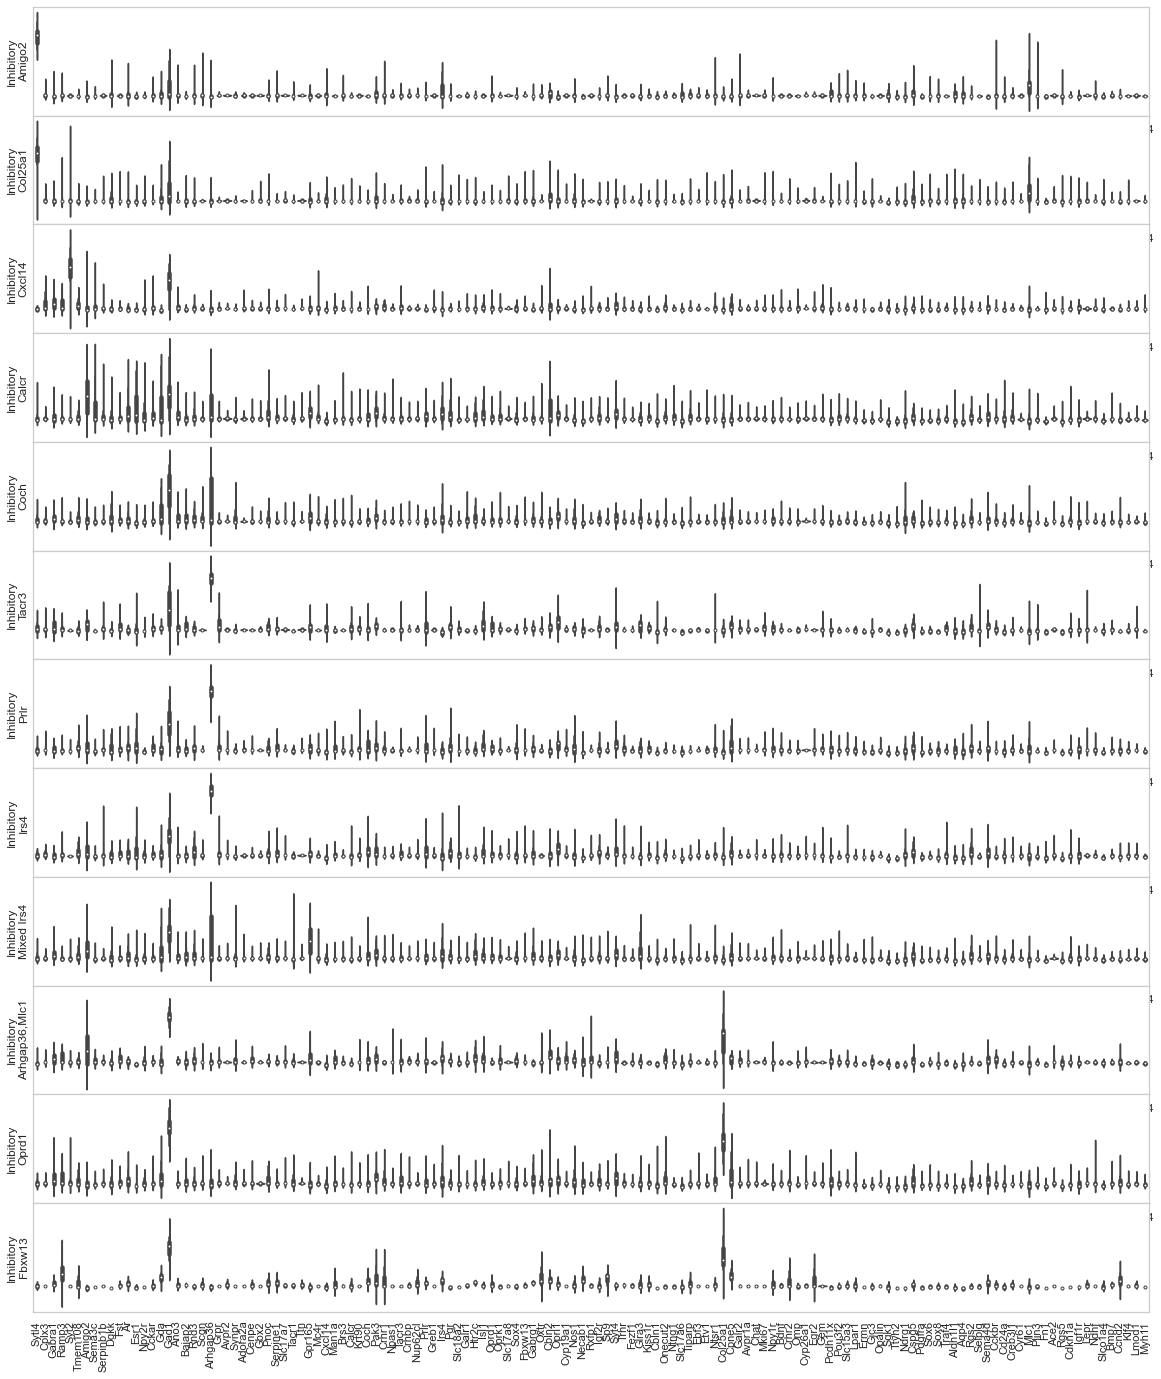

In [49]:
s = 13
e = 25

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

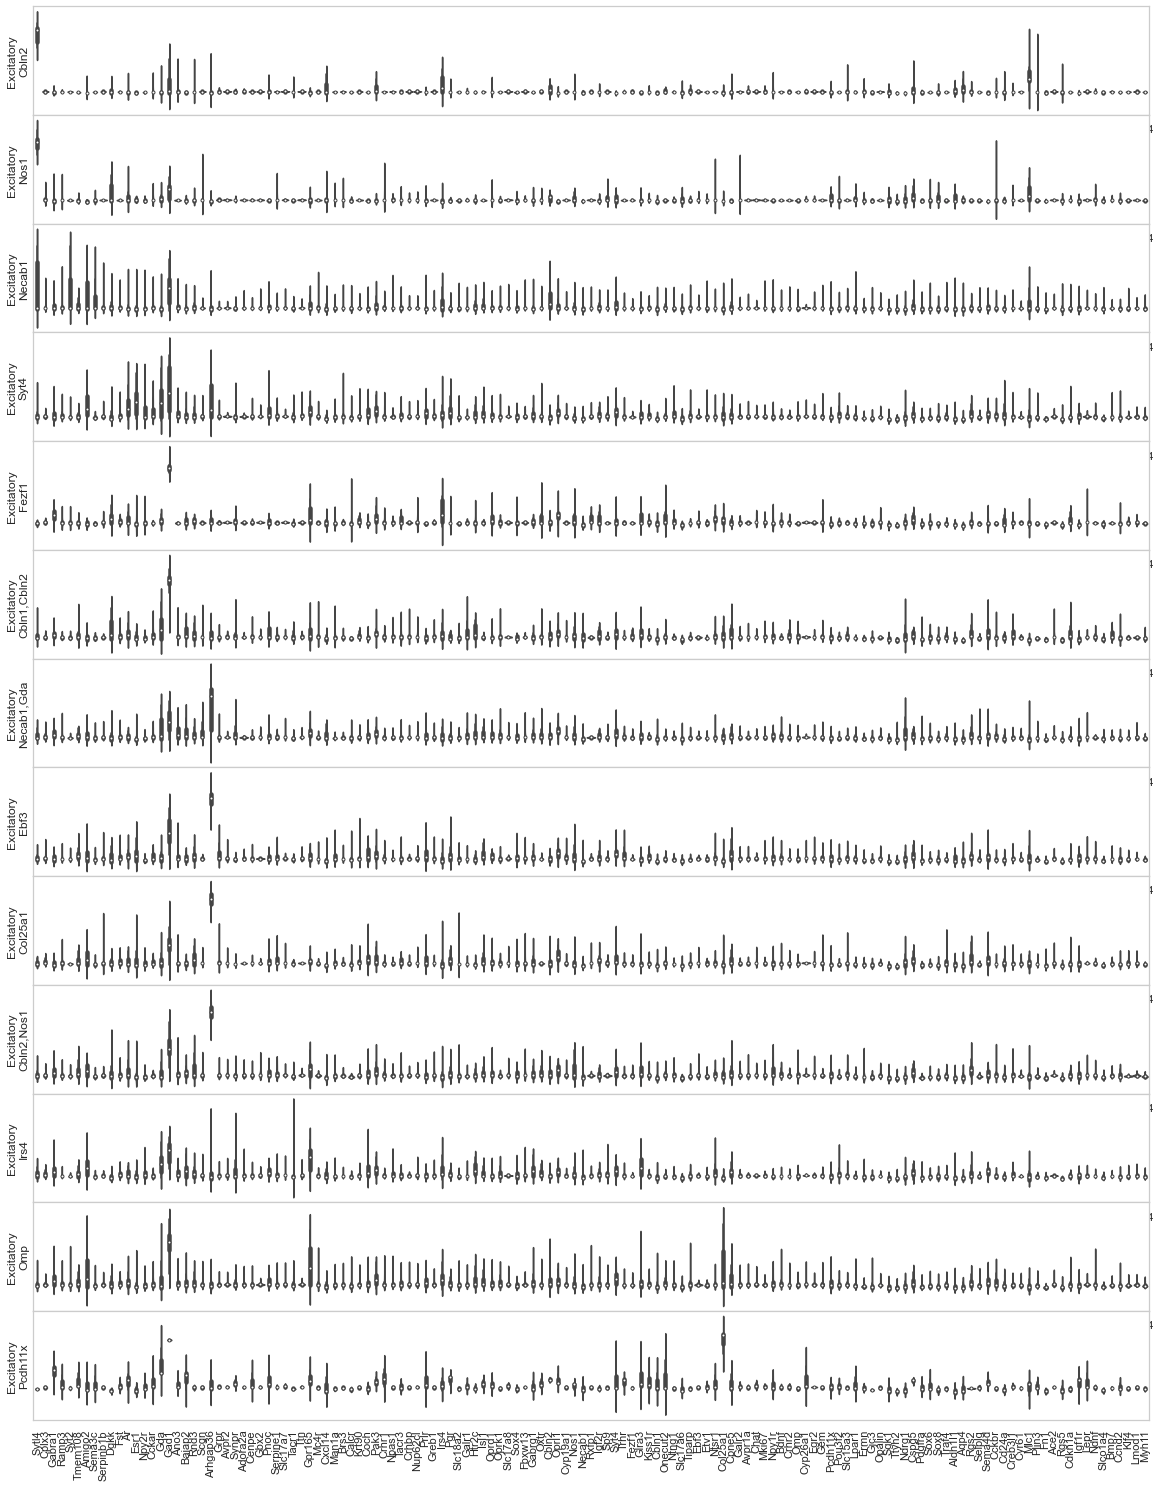

In [51]:
s = 25
e = 38

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

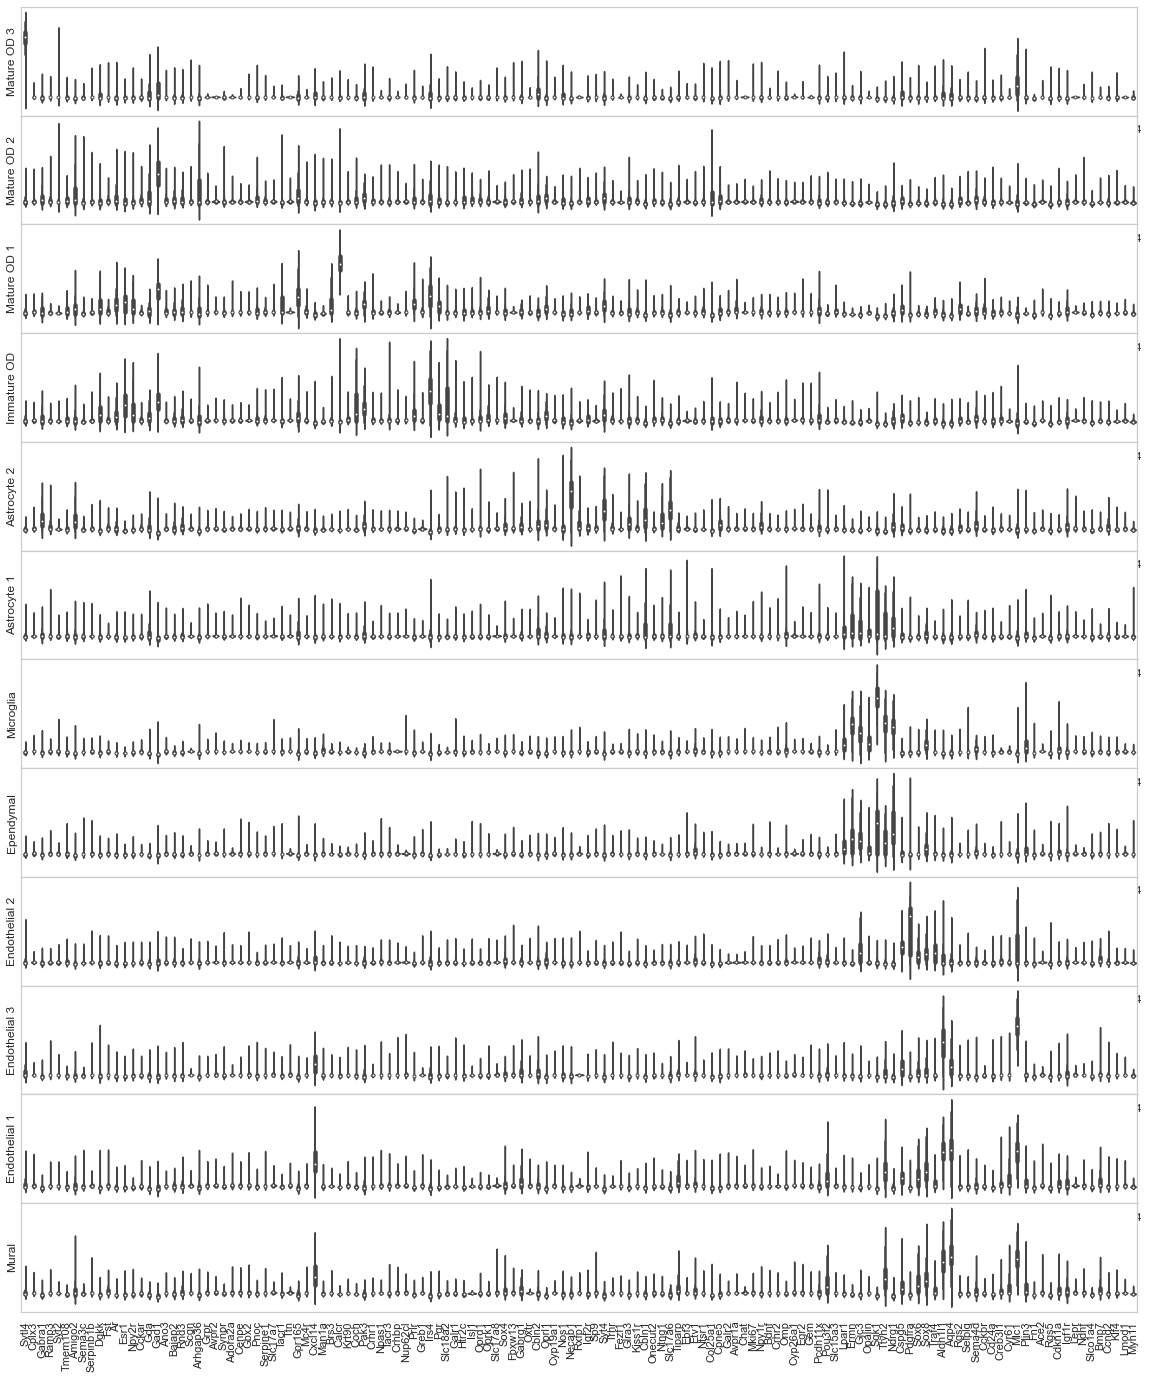

In [50]:
s = 38
e = None

indices = heatmap_clusters_index[s:e]
acc_lens = acc_sizes[s:e]
ylabels = heatmap_clusters_ordered_short[s:e]

fig, axes = plt.subplots(len(indices), 1, figsize=[20, len(indices)*2])
plt.subplots_adjust(hspace=0)
for idx in range(len(indices)):
    acc_idx = np.sum(acc_lens[:idx]).astype(int)
    cl_vecs = gene_exp_heatmap.T[acc_idx:acc_idx+acc_lens[idx]]
    sns.violinplot(ax=axes[idx], data=cl_vecs, width=1)
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_yticks([])
axes[idx].set_xticklabels(heatmap_genes_ordered, rotation=90)
pass

In [56]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, min_blob_area=7, fill_blobs=True)

In [57]:
plt.figure(figsize=[5, 5])
ds.plot_celltypes_map(rotate=3, background='white', colors=denovo_celltype_colors, set_alpha=False, z=4)
from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().axis('off')
plt.tight_layout()

NameError: name 'denovo_celltype_colors' is not defined

<Figure size 360x360 with 0 Axes>

In [58]:
lbl_bot, lbl_left, df, ms_heatmap = calc_matching_score(ds.centroids, denovo_labels_final)
df

Reference cell types          Given cell types  Pearson's r  \
0             Astrocyte               Astrocyte 1         0.94   
1         OD Immature 1               Immature OD         0.92   
2                  I-31  Inhibitory Amigo2,Sema3c         0.91   
3                  I-27           Inhibitory Gad1         0.93   
4                  E-14           Excitatory Syt4         0.88   
5                  E-19    Excitatory Cbln1,Cbln2         0.85   
6           OD Mature 2               Mature OD 2         0.97   
7             Pericytes                     Mural         0.96   
8                   E-9     Excitatory Necab1,Gda         0.92   
9                  I-19         Inhibitory Gpr165         0.80   
10                  I-7         Inhibitory Amigo2         0.85   
11                 I-18        Inhibitory Col25a1         0.89   
12        Endothelial 3             Endothelial 3         0.98   
13            Microglia                 Microglia         0.98   
14                  E-5           Excitatory Ebf3         0.86   
15        Endothelial 1             Endothelial 1         0.93   
16            Ependymal                 Ependymal         0.92   
17                 I-15           Inhibitory Irs4         0.88   

    Matched segments  Total segments  Matching score  
0                709             745            0.95  
1                220             223            0.99  
2                 23              23            1.00  
3                 10              12            0.83  
4                175             298            0.59  
5                 48              50            0.96  
6                240             241            1.00  
7                 60              62            0.97  
8                 16              19            0.84  
9                  6              11            0.55  
10               129             245            0.53  
11                72             135            0.53  
12               108             117            0.92  
13                99             106            0.93  
14                 1               1            1.00  
15               239             301            0.79  
16               219             219            1.00  
17               112             174            0.64

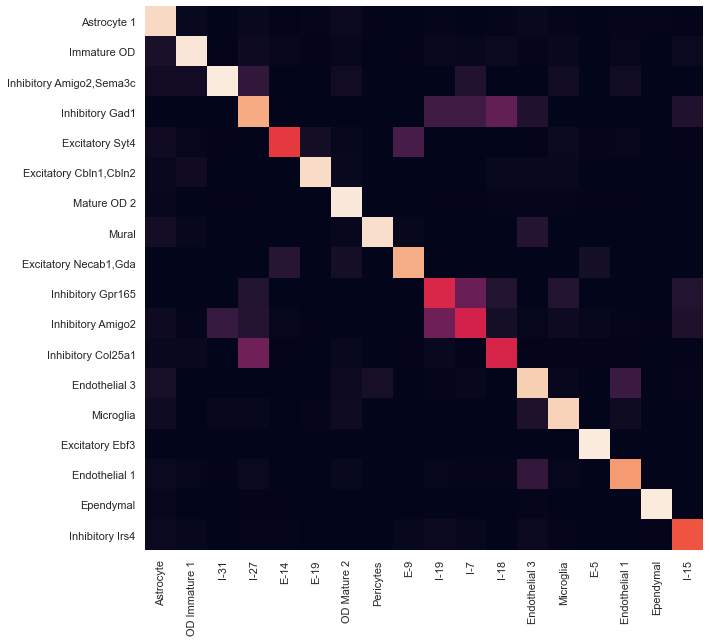

In [59]:
plt.figure(figsize=[10, 10])
sns.heatmap(ms_heatmap,
            yticklabels=lbl_bot,
            xticklabels=lbl_left, cbar=False, vmin=0, vmax=1)
pass

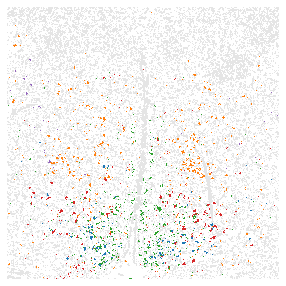

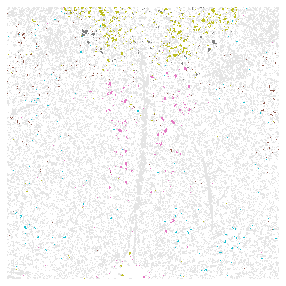

In [55]:
indices = [[39, 16, 45, 34, 14], [19, 42, 25, 8, 36]]
colors = plt.get_cmap('tab10')(range(10))
#np.random.shuffle(colors)
i = 0
for subindices in indices:
    plt.figure(figsize=[5, 5])
    ctmap = np.zeros([ds.filtered_celltype_maps.shape[1], ds.filtered_celltype_maps.shape[0], 4])
    ctmap[ds.filtered_celltype_maps[..., 0].T > -1] = [0.9, 0.9, 0.9, 1]
    for idx in subindices:
        cluster_color = to_rgba(denovo_celltype_colors[idx])
        ctmap[ds.filtered_celltype_maps[..., 0].T == idx] = colors[i]
        plt.imshow(ctmap)
        plt.xlim([0, ds.celltype_maps.shape[0]])
        plt.ylim([0, ds.celltype_maps.shape[1]])
        plt.axis('off')
        i += 1

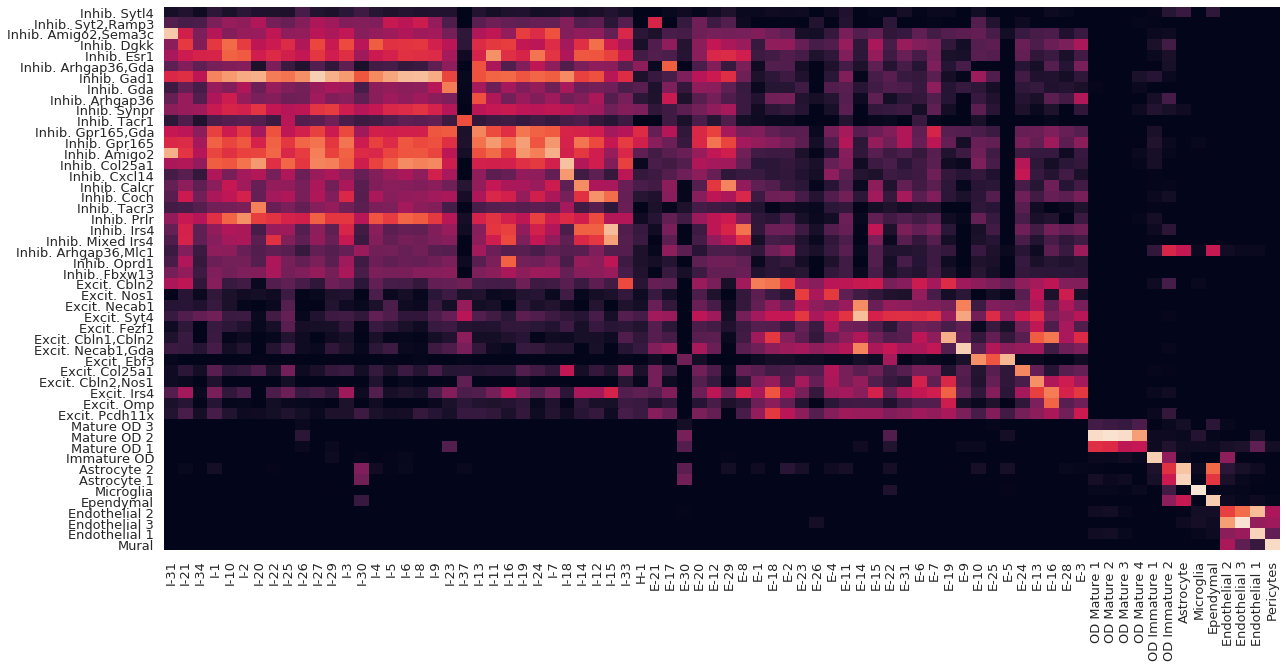

In [56]:
centroid_corrs = np.zeros([len(merfish_centroids), len(ds.centroids)])

for i, mc in enumerate(merfish_centroids):
    for j, dc in enumerate(ds.centroids):
        centroid_corrs[i, j] = ssam.utils.corr(mc, dc)
centroid_corrs = centroid_corrs[:, heatmap_clusters_index]

heatmap_cls_index = []
heatmap_cls_ordered = []
cur_pos = 0
for cate in ['I-', 'H-', 'E-', 'OD Mature', 'OD Immature', 'Astrocyte',
              'Microglia', 'Ependymal', 'Endothelial', 'Pericytes']:
    cate_indices = np.where([cate in e for e in merfish_uniq_labels])[0]
    max_corr_indices = np.argmax(centroid_corrs[cate_indices, :], axis=1)
    for i in np.unique(max_corr_indices):
        cl_cl_indices = cate_indices[np.where(max_corr_indices == i)[0]]
        heatmap_cls_index += list(cl_cl_indices)
        heatmap_cls_ordered += list(np.array(merfish_uniq_labels)[cl_cl_indices])
centroid_corrs = centroid_corrs[heatmap_cls_index, :]

plt.figure(figsize=[20, 10])
ax_heatmap = sns.heatmap(centroid_corrs.T,
                         xticklabels=merfish_uniq_labels[heatmap_cls_index],
                         yticklabels=heatmap_clusters_ordered,
                         vmin=0, vmax=1, cbar=False)
ax_heatmap.set_xticklabels(merfish_uniq_labels[heatmap_cls_index], fontsize = 13)
ax_heatmap.set_yticklabels(shorten_labels(heatmap_clusters_ordered), fontsize = 13)
pass

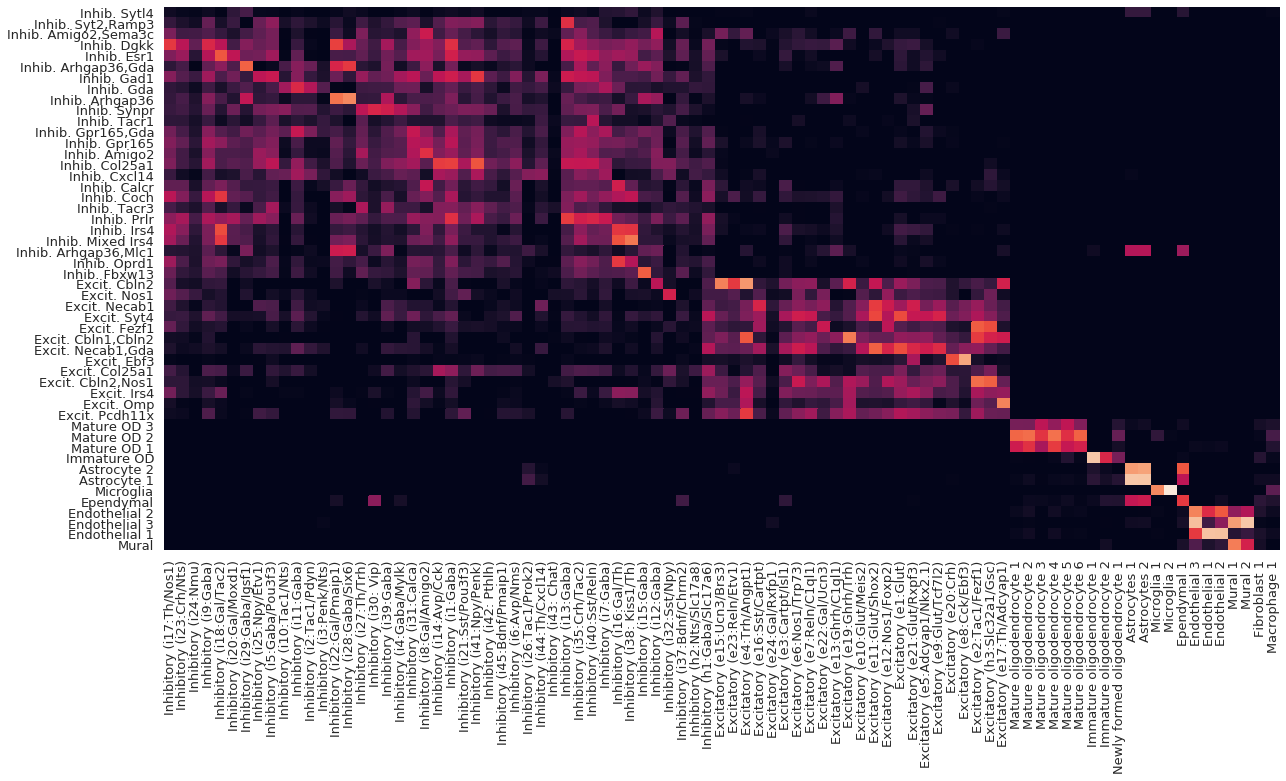

In [57]:
centroid_corrs = np.zeros([len(scrna_centroids), len(ds.centroids)])

for i, mc in enumerate(scrna_centroids):
    for j, dc in enumerate(ds.centroids):
        centroid_corrs[i, j] = ssam.utils.corr(mc, dc)
centroid_corrs = centroid_corrs[:, heatmap_clusters_index]

heatmap_cls_index = []
heatmap_cls_ordered = []
cur_pos = 0
for cate in ['Inhibitory (i', 'Inhibitory (h', 'Excitatory', 'Mature',
              'Immature', 'Newly formed', 'Astrocytes', 'Microglia', 'Ependymal', 'Endothelial',
              'Mural', 'Fibroblast', 'Macrophage']:
    cate_indices = np.where([cate in e for e in scrna_uniq_labels])[0]
    max_corr_indices = np.argmax(centroid_corrs[cate_indices, :], axis=1)
    for i in np.unique(max_corr_indices):
        cl_cl_indices = cate_indices[np.where(max_corr_indices == i)[0]]
        heatmap_cls_index += list(cl_cl_indices)
        heatmap_cls_ordered += list(np.array(scrna_uniq_labels)[cl_cl_indices])
centroid_corrs = centroid_corrs[heatmap_cls_index, :]

plt.figure(figsize=[20, 10])
ax_heatmap = sns.heatmap(centroid_corrs.T, yticklabels=heatmap_clusters_ordered, xticklabels=np.array(scrna_uniq_labels)[heatmap_cls_index], vmin = 0, vmax = 1, cbar = False)
ax_heatmap.set_yticklabels(shorten_labels(heatmap_clusters_ordered), fontsize = 13)
ax_heatmap.set_xticklabels(np.array(scrna_uniq_labels)[heatmap_cls_index], fontsize = 13)
pass

In [58]:
for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx,
                            cluster_name=denovo_labels_short[idx],
                            cluster_color=denovo_celltype_colors[idx])
    plt.tight_layout()
    plt.savefig('diagplots_MERFISH/diagplot_centroid_%d_after_merging_removing.png'%idx)
    plt.close()    

Find cell-class domains

In [59]:
# Save the current cell-type map
filtered_celltype_maps_backup = np.array(ds.filtered_celltype_maps, copy=True)

In [60]:
# Convert cell-type map to cell-class map
ds.filtered_celltype_maps = np.zeros_like(filtered_celltype_maps_backup)
ds.filtered_celltype_maps[:] = -1
for cate_idx, cate in enumerate(heatmap_cell_class_ordered):
    cl_indices = np.where(np.array(denovo_celltype_colors) == cell_class_colors[cate])[0]
    for cl_idx in cl_indices:
        ds.filtered_celltype_maps[filtered_celltype_maps_backup == cl_idx] = cate_idx

In [61]:
analysis.bin_celltypemaps(step=10, radius=100)

In [62]:
analysis.find_domains(n_clusters=20, merge_remote=True, merge_thres=0.8, norm_thres=4000)

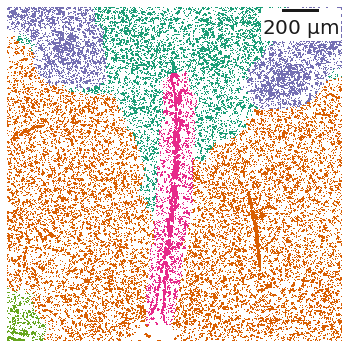

In [63]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[5, 5])
cmap = ListedColormap([
    '#66a61e',
    '#d95f02',
    '#e7298a',
    '#1b9e77',
    '#7570b3',
])
ds.plot_domains(rotate=3, cmap=cmap, z=0)
plt.axis('off')
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.tight_layout()

In [64]:
analysis.calc_cell_type_compositions()

In [65]:
domain_labels = [
    'Boundary',
    'Inhibitory',
    'Ventricle',
    'Excitatory',
    'ODs',
]

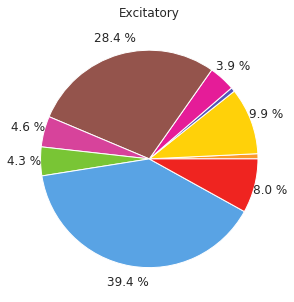

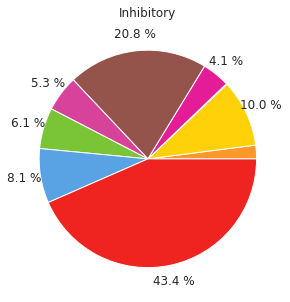

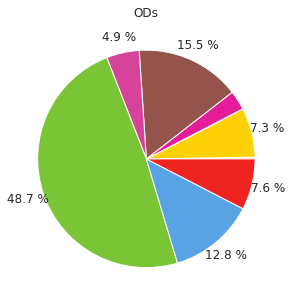

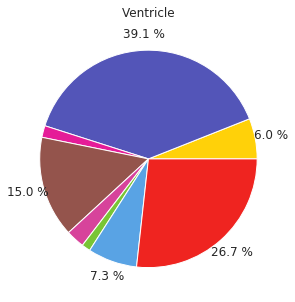

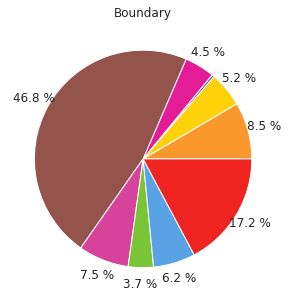

In [66]:
cols = [cell_class_colors[cl] for cl in heatmap_cell_class_ordered]
cell_class_orders = range(len(heatmap_cell_class_ordered))[::-1]
for domain_idx in [3, 1, 4, 2, 0]:
    plt.figure(figsize=[5, 5])
    ds.plot_celltype_composition(domain_idx,
                                 cell_type_colors=cols,
                                 cell_type_orders=cell_class_orders,
                                 label_cutoff=0.03)
    plt.title(domain_labels[domain_idx])

Text(0.5, 1.0, 'All')

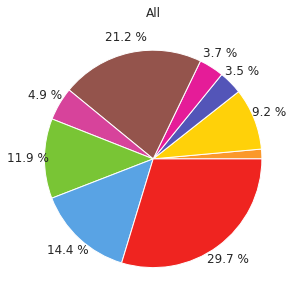

In [67]:
plt.figure(figsize=[5, 5])
ds.plot_celltype_composition(domain_index=5,
                             cell_type_colors=cols,
                             cell_type_orders=cell_class_orders,
                             label_cutoff=0.03)
plt.title('All')

## Reproduce original result in Moffit *et al*.

In [23]:
ct_convert_dic = {
    "Astrocyte": "Astrocyte",
    "Endothelial 1": "Endothelial",
    "Endothelial 2": "Endothelial",
    "Endothelial 3": "Endothelial",
    "Ependymal": "Ependymal",
    "Excitatory": "Excitatory",
    "Inhibitory": "Inhibitory",
    "Microglia": "Microglia",
    "OD Immature 1": "Immature OD",
    "OD Immature 2": "Immature OD",
    "OD Mature 1": "Mature OD",
    "OD Mature 2": "Mature OD",
    "OD Mature 3": "Mature OD",
    "OD Mature 4": "Mature OD",
    "Pericytes": "Mural",
}

from matplotlib.colors import to_rgba
seg_ct_col_dic = {}
for c1, c2 in ct_convert_dic.items():
    seg_ct_col_dic[c1] = to_rgba(cell_class_colors[c2])

In [24]:
from collections import defaultdict
cell_boundaries = []
with open('zenodo/MERFISH/raw_data/cellboundaries_example_animal.csv') as f:
    f.readline()
    for line in f:
        entries = line.rstrip().split(',')
        if len(entries) == 0:
            break
        if entries[1] == '':
            continue
        x = [float(e) for e in entries[1].split(';')]
        y = [float(e) for e in entries[2].split(';')]
        try:
            cell_type = cid_dic[entries[0]]
            neuronal_cell_type = cid_nct_dic[entries[0]]
            cell_boundaries.append((x, y, cell_type, neuronal_cell_type))
        except KeyError:
            pass

In [31]:
from skimage.draw import polygon

img_shape = [1800, 1800]
seg_im = np.zeros(img_shape + [4])
seg_map = np.zeros(img_shape, dtype=int)
seg_ctmap = np.zeros(img_shape, dtype=int)
minxy = [9999999999, 9999999999]
maxxy = [-9999999999, -9999999999]
for x, y, _, _ in cell_boundaries:
    minx, miny, maxx, maxy = min(x), min(y), max(x), max(y)
    if minxy[0] > minx:
        minxy[0] = minx
    if minxy[1] > miny:
        minxy[1] = miny
    if maxxy[0] < maxx:
        maxxy[0] = maxx
    if maxxy[1] < maxy:
        maxxy[1] = maxy
for idx, (x, y, cell_type, neuronal_cell_type) in enumerate(cell_boundaries, start=1):
    X, Y = [], []
    for xx, yy in zip(x, y):
        try:
            xxx, yyy = int(xx - minxy[0]), int(yy - minxy[1])
            X.append(xxx)
            Y.append(yyy)
        except ValueError:
            continue
    p = polygon(X, Y, img_shape)
    seg_im[p] = seg_ct_col_dic[cell_type]
    if neuronal_cell_type != '':
        cell_type = neuronal_cell_type
    seg_map[p] = idx
    seg_ctmap[p] = list(merfish_uniq_labels).index(cell_type)
#print(maxxy[0] - minxy[0])
#print(maxxy[1] - minxy[1])

In [32]:
seg_map = seg_map[5:1795, :][:, :1790]
seg_ctmap = seg_ctmap[5:1795, :][:, :1790]

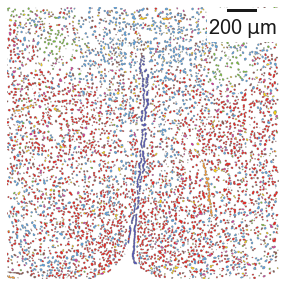

In [26]:
plt.figure(figsize=[5, 5])
plt.imshow(seg_im.swapaxes(0, 1))
plt.xlim([5, 1800])
plt.ylim([0, 1795])
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
plt.show()

In [27]:
import pandas as pd
from scipy.spatial.distance import cdist

def calc_matching_score(centroids, uniq_labels):
    m_corrs = cdist(centroids, merfish_centroids, ssam.utils.corr)
    max_mask = m_corrs > 0.8
    max_mask &= m_corrs == m_corrs.max(axis=0)
    max_mask &= (m_corrs.T == m_corrs.max(axis=1)).T
    x, y = np.where(max_mask)
    high_corr_labels_bot = np.array(uniq_labels)[x]
    high_corr_labels_left = np.array(merfish_uniq_labels)[y]

    hm_total = np.zeros([len(x), len(centroids)], dtype=int)
    hm = np.zeros([len(x), len(centroids)])

    for i, idx in enumerate(y):
        cell_indices = np.unique(seg_map[seg_ctmap == idx])
        hm_total[i, :] = len(cell_indices)
        for j in cell_indices:
            ssam_seg = ds.celltype_maps[..., 4][seg_map == j]
            ssam_cts, ssam_ctcnts = np.unique(ssam_seg, return_counts=True)
            ssam_ctfreqs = ssam_ctcnts / len(ssam_seg)
            hm[i, ssam_cts] += (ssam_ctfreqs > 0.1).astype(int)
    ms = (hm / hm_total)[:, x]
    df = pd.DataFrame({
        "Reference cell types": np.array(merfish_uniq_labels)[y],
        "Given cell types": np.array(uniq_labels)[x],
        "Pearson's r": np.round(m_corrs[x, y], 2),
        "Matched segments": np.diag(hm[:, x].astype(int)),
        "Total segments": np.diag(hm_total[:, x]),
        "Matching score": np.round(np.diag(ms), 2),
    })
    return high_corr_labels_bot, high_corr_labels_left, df, ms